# HW1_Сравнительный анализ моделей классификации отзывов

**ФИО Студента:** Лаврухина Виктория

**Дата Выполнения:** 11.09.2025

-----

## **1. Подготовка данных и EDA**

### **1.1. Загрузка и подготовка библиотек**

Начнем с установки и импорта необходимых библиотек для нашего проекта.

In [1]:
# Установка библиотек
!pip install pymorphy3
!pip install gensim
!pip install lime

In [27]:
# Основные библиотеки
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
import pickle
from datetime import datetime
from itertools import product
from collections import defaultdict

# NLP библиотеки
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pymorphy3

# Embeddings
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
import gensim.downloader as api

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc, RocCurveDisplay)
from sklearn.pipeline import Pipeline

# Визуализация
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud

# Интерпретируемость
import shap
import lime

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

# Создание структуры папок
folders = ['data', 'models', 'results', 'visualizations', 'reports']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Загрузка ресурсов NLTK
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)
print("NLTK ресурсы загружены")

# Инициализация морфологического анализатора и стоп-слов
morph = pymorphy3.MorphAnalyzer()
stop_words_ru = set(stopwords.words('russian'))
stop_words_en = set(stopwords.words('english'))

NLTK ресурсы загружены


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### **1.2. Загрузка и первичный анализ данных**

Загрузим датасет и проведем базовый анализ, чтобы понять его структуру.

In [3]:
# Загрузка датасета
from datasets import load_dataset
df = load_dataset("d0rj/geo-reviews-dataset-2023")
df = pd.DataFrame(df['train'])

# ЗАДАНИЕ: Удалите нейтральные отзывы (рейтинг 3) и создайте бинарную целевую переменную 'sentiment'.
# 1 - позитивный отзыв (рейтинг 4, 5)
# 0 - негативный отзыв (рейтинг 1, 2)
# Удалите строки с отсутствующими значениями в 'sentiment'.
df = df[df["rating"] != 3].copy()
df["sentiment"] = df["rating"].apply(lambda x: 1 if x >= 4 else 0)


# ЗАДАНИЕ: Сбалансируйте классы, чтобы количество позитивных и негативных отзывов было одинаковым.
min_count = df["sentiment"].value_counts().min()
df = (
    df.groupby("sentiment", group_keys=False)
      .apply(lambda x: x.sample(min_count, random_state=42))
      .reset_index(drop=True)
)


# Вывод базовой информации о датасете
print("Исследовательский анализ данных:")
print(f"\nРазмер датасета: {df.shape}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПропущенные значения:\n{df.isnull().sum()}")

# Распределение классов
class_distribution = df['sentiment'].value_counts()
print("\nРаспределение классов:")
print(f"Позитивные (1): {class_distribution.get(1, 0)} ({class_distribution.get(1, 0)/len(df)*100:.1f}%)")
print(f"Негативные (0): {class_distribution.get(0, 0)} ({class_distribution.get(0, 0)/len(df)*100:.1f}%)")

Исследовательский анализ данных:

Размер датасета: (93278, 6)

Типы данных:
address      object
name_ru      object
rating        int64
rubrics      object
text         object
sentiment     int64
dtype: object

Пропущенные значения:
address        0
name_ru      167
rating         0
rubrics        0
text           0
sentiment      0
dtype: int64

Распределение классов:
Позитивные (1): 46639 (50.0%)
Негативные (0): 46639 (50.0%)


### **1.3. Исследовательский анализ данных (EDA)**

Проведем более глубокий анализ текстовых данных и визуализируем результаты.


Статистика текстов:
        text_length    word_count  sentence_count
count  93278.000000  93278.000000    93278.000000
mean     401.016885     73.020980        5.241654
std      407.419661     76.148805        4.827636
min        2.000000      1.000000        1.000000
25%      166.000000     29.000000        2.000000
50%      274.000000     49.000000        4.000000
75%      495.000000     90.000000        7.000000
max    20162.000000   3608.000000      190.000000


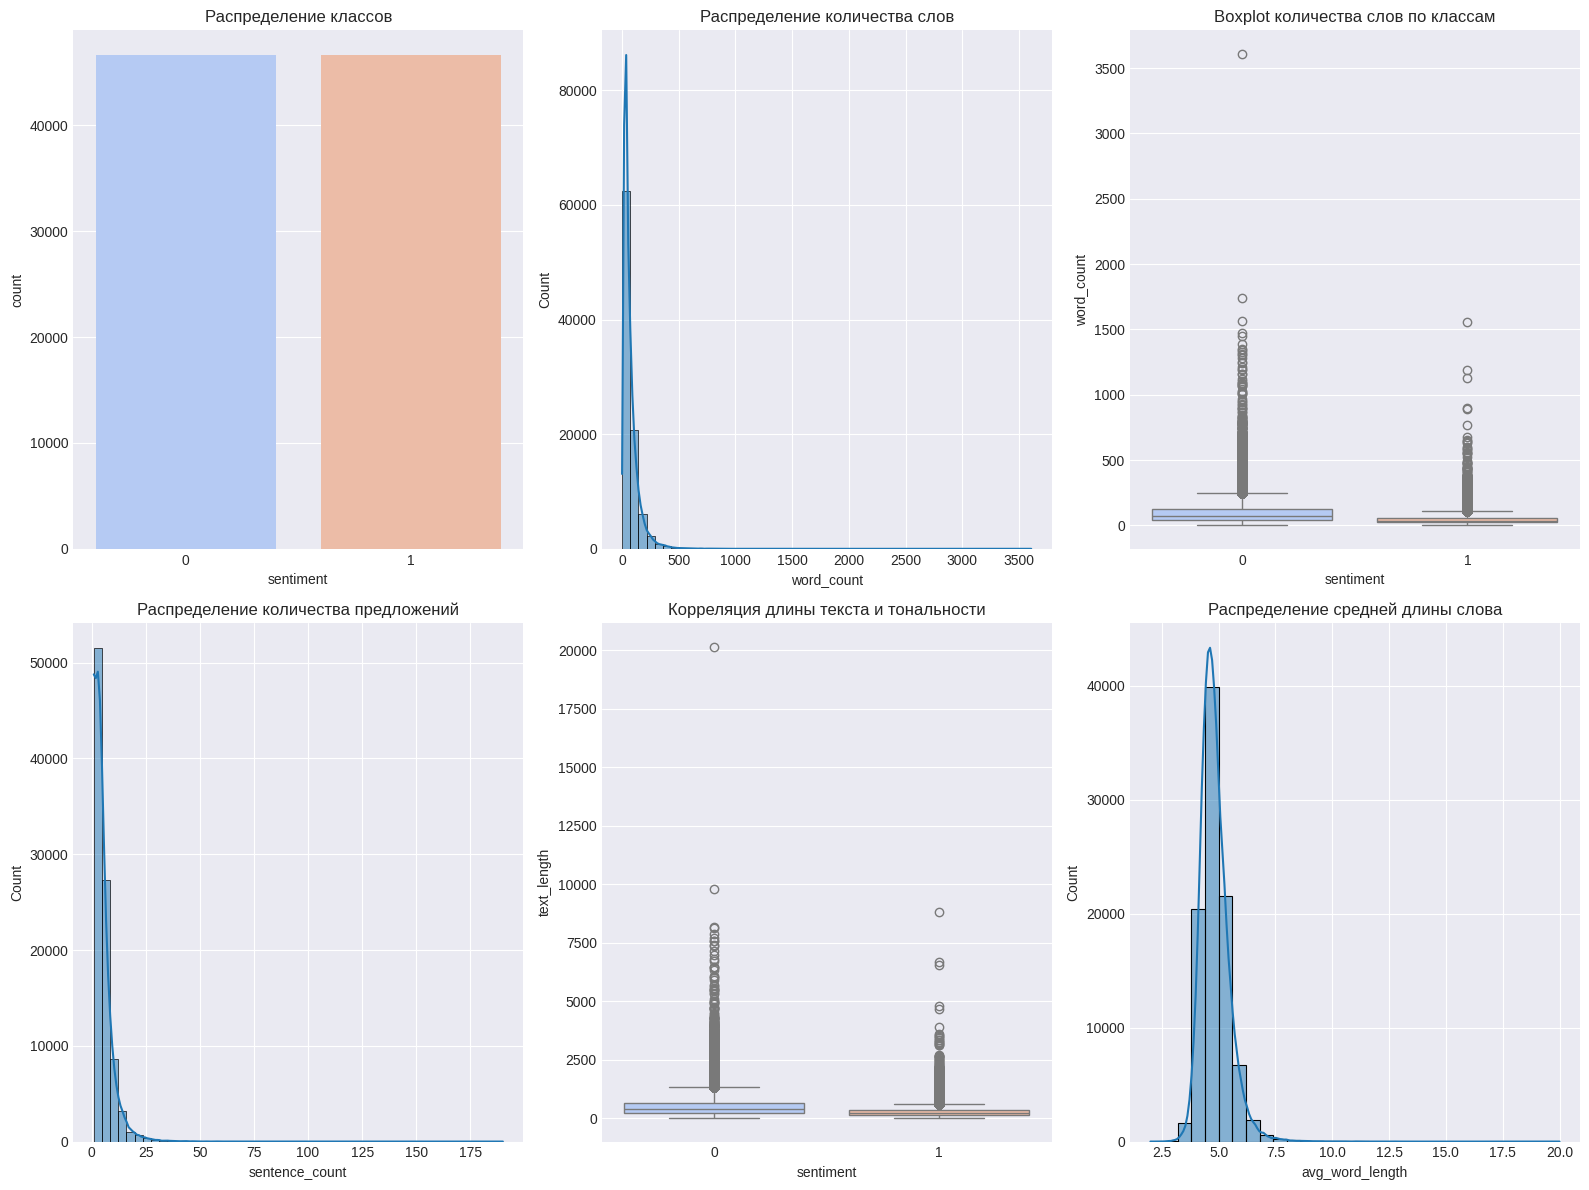

In [4]:
# ЗАДАНИЕ: Добавьте в датафрейм столбцы с длиной текста, количеством слов и предложений.
df['text_length'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(word_tokenize(x)))
df['sentence_count'] = df['text'].astype(str).apply(lambda x: len(sent_tokenize(x)))
df['avg_word_length'] = df['text'].astype(str).apply(
    lambda x: np.mean([len(w) for w in word_tokenize(x)]) if len(word_tokenize(x)) > 0 else 0
)

# Вывод статистик по текстам
print("\nСтатистика текстов:")
print(df[['text_length', 'word_count', 'sentence_count']].describe())

# ЗАДАНИЕ: Создайте 6 графиков для визуализации EDA, например такие:
plt.figure(figsize=(16, 12))

# 1. Распределение классов
plt.subplot(2, 3, 1)
sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.title("Распределение классов")

# 2. Распределение количества слов
plt.subplot(2, 3, 2)
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Распределение количества слов")

# 3. Boxplot количества слов по классам
plt.subplot(2, 3, 3)
sns.boxplot(x='sentiment', y='word_count', data=df, palette='coolwarm')
plt.title("Boxplot количества слов по классам")

# 4. Распределение количества предложений
plt.subplot(2, 3, 4)
sns.histplot(df['sentence_count'], bins=50, kde=True)
plt.title("Распределение количества предложений")

# 5. Корреляция длины и sentiment
plt.subplot(2, 3, 5)
sns.boxplot(x='sentiment', y='text_length', data=df, palette='coolwarm')
plt.title("Корреляция длины текста и тональности")

# 6. Средняя длина слова
plt.subplot(2, 3, 6)
sns.histplot(df['avg_word_length'], bins=30, kde=True)
plt.title("Распределение средней длины слова")

plt.tight_layout()
plt.show()

-----

## **2. Предобработка текста**

На этом этапе мы создадим функцию для полной предобработки текстовых данных.  

- Напишите функцию, выполняющую лемматизацию, удаление стоп-слов, знаков препинания и приведение к нижнему регистру.  
- Примените функцию для создания колонки с обработанным текстом.   
- Проведите частотный анализ слов и визуализируйте облака слов для позитивных и негативных классов.  
- Разделите данные на обучающую, валидационную и тестовую выборки.  



Эффект предобработки:
Средняя длина до обработки: 73.0 слов
После полной обработки: 39.8 слов

Топ-10 слов (позитив): [('очень', 29816), ('хороший', 14366), ('место', 10933), ('персонал', 9823), ('отличный', 9410), ('это', 8512), ('спасибо', 8028), ('магазин', 7454), ('вкусный', 7295), ('рекомендовать', 7147)]
Топ-10 слов (негатив): [('это', 27842), ('очень', 16141), ('который', 14851), ('сказать', 13749), ('такой', 11834), ('день', 11439), ('просто', 11246), ('человек', 10175), ('время', 10006), ('место', 9524)]


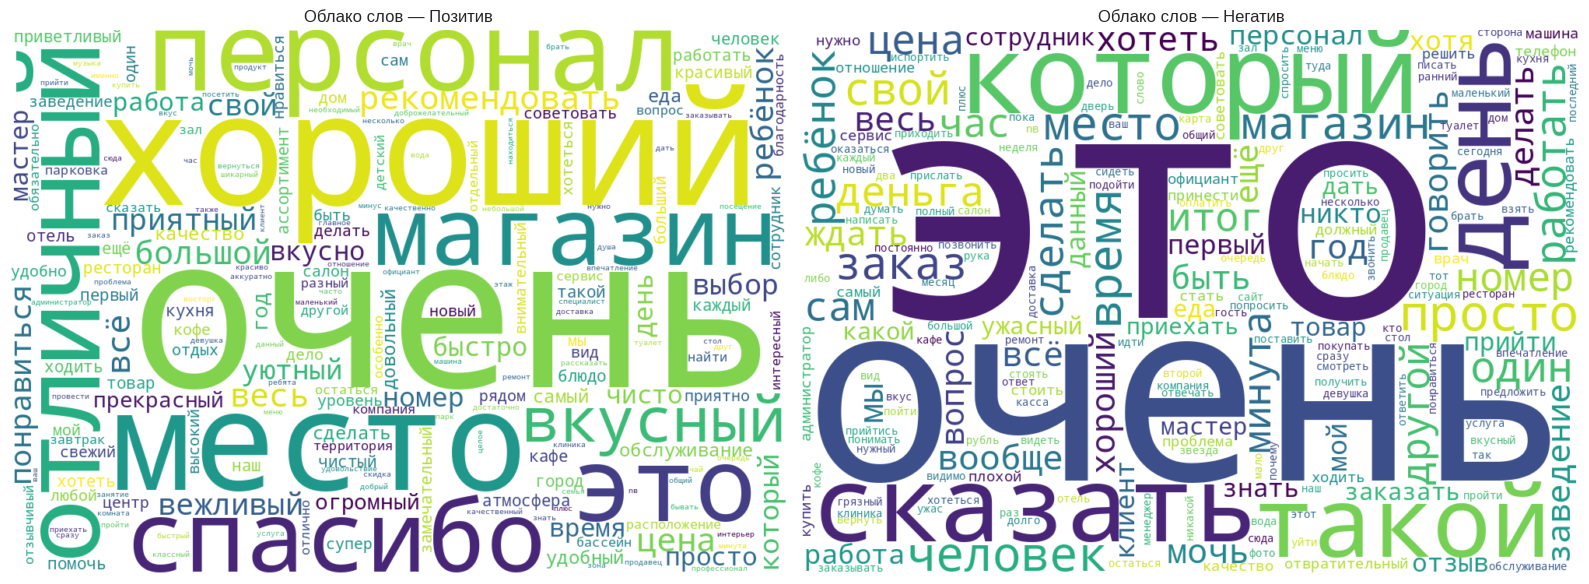

In [5]:
# функция предобработки
_clean_html = re.compile(r"<.*?>")
_clean_url  = re.compile(r"http\S+|www\.\S+")
_keep_chars = re.compile(r"[^a-zA-Zа-яА-ЯёЁ0-9\s]+")

def preprocess_text(text,
                    language='ru',
                    use_lemmatization=True,
                    remove_stopwords=True,
                    min_word_length=2):
    """
    Полный pipeline предобработки текста.
    """
    # ЗАДАНИЕ: Реализуйте шаги предобработки:
    # 1. Приведение к нижнему регистру
    s = text.lower()

    # 2. Удаление HTML и URLs
    s = _clean_html.sub(" ", s)
    s = _clean_url.sub(" ", s)

    # 3. Удаление спецсимволов
    s = _keep_chars.sub(" ", s)

    # 4. Удаление лишних пробелов
    s = re.sub(r"\s+", " ", s).strip()

    # 5. Токенизация
    tokens = word_tokenize(s, language='russian' if language == 'ru' else 'english')

    # 6. Удаление стоп-слов
    if remove_stopwords:
        if language == 'ru':
            sw = stop_words_ru
        else:
            sw = stop_words_en
        tokens = [t for t in tokens if t not in sw]

    # 7. Лемматизация
    if use_lemmatization and language == 'ru':
        lemmas = []
        for t in tokens:
            # пропускаем полностью цифровые токены, лемматизация им не нужна
            if t.isdigit():
                lemmas.append(t)
                continue
            p = morph.parse(t)
            if p:
                lemmas.append(p[0].normal_form)
            else:
                lemmas.append(t)
        tokens = lemmas

    # 8. Фильтрация по длине слова
    tokens = [t for t in tokens if len(t) >= min_word_length]

    return ' '.join(tokens)

# ЗАДАНИЕ: Примените вашу функцию к столбцу 'text' и создайте новый столбец 'processed_text'.
df['processed_text'] = df['text'].apply(preprocess_text)

# Анализ результатов предобработки
print("\nЭффект предобработки:")
print(f"Средняя длина до обработки: {df['word_count'].mean():.1f} слов")
print(f"После полной обработки: {df['processed_text'].str.split().str.len().mean():.1f} слов")

# ЗАДАНИЕ: Проведите частотный анализ слов и создайте облака слов для позитивных и негативных отзывов.
# частотный анализ
def top_n_words(series_of_texts, n=30):
    counter = Counter()
    for line in series_of_texts:
        counter.update(line.split())
    return counter.most_common(n)

top_pos = top_n_words(df.loc[df['sentiment'] == 1, 'processed_text'], n=30)
top_neg = top_n_words(df.loc[df['sentiment'] == 0, 'processed_text'], n=30)

print("\nТоп-10 слов (позитив):", top_pos[:10])
print("Топ-10 слов (негатив):", top_neg[:10])

# облака слов
pos_text_concat = " ".join(df.loc[df['sentiment'] == 1, 'processed_text'])
neg_text_concat = " ".join(df.loc[df['sentiment'] == 0, 'processed_text'])

wc_pos = WordCloud(width=1000, height=700, background_color="white",
                   collocations=False).generate(pos_text_concat)
wc_neg = WordCloud(width=1000, height=700, background_color="white",
                   collocations=False).generate(neg_text_concat)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов — Позитив")

plt.subplot(1, 2, 2)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов — Негатив")
plt.tight_layout()
plt.show()


-----

## **3. TF-IDF + LogisticRegression**

Векторизуем текст с помощью TF-IDF и обучим модель логистической регрессии.

- Подберите оптимальные параметры TfidfVectorizer (например, max_features, ngram_range), оценивая F1-score на валидационной выборке.  
- Обучите LogisticRegression на лучших TF-IDF признаках.  
- Оцените итоговое качество на тестовой выборке. Выведите отчет с метриками и confusion matrix.  
- Проанализируйте важность признаков (коэффициенты модели).  



Тестируем параметры: {'max_features': 1000, 'ngram_range': (1, 1)}
F1-score на валидации: 0.9296

Тестируем параметры: {'max_features': 1000, 'ngram_range': (1, 2)}
F1-score на валидации: 0.9298

Тестируем параметры: {'max_features': 2000, 'ngram_range': (1, 1)}
F1-score на валидации: 0.9362

Тестируем параметры: {'max_features': 2000, 'ngram_range': (1, 2)}
F1-score на валидации: 0.9367

Тестируем параметры: {'max_features': 5000, 'ngram_range': (1, 1)}
F1-score на валидации: 0.9408

Тестируем параметры: {'max_features': 5000, 'ngram_range': (1, 2)}
F1-score на валидации: 0.9426

Тестируем параметры: {'max_features': 10000, 'ngram_range': (1, 1)}
F1-score на валидации: 0.9427

Тестируем параметры: {'max_features': 10000, 'ngram_range': (1, 2)}
F1-score на валидации: 0.9434

Лучшие параметры: {'max_features': 10000, 'ngram_range': (1, 2)}
Лучший F1-score: 0.9434

=== ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ ===
Accuracy:  0.9455
Precision: 0.9472
Recall:    0.9437
F1-score:  0.9454
RO

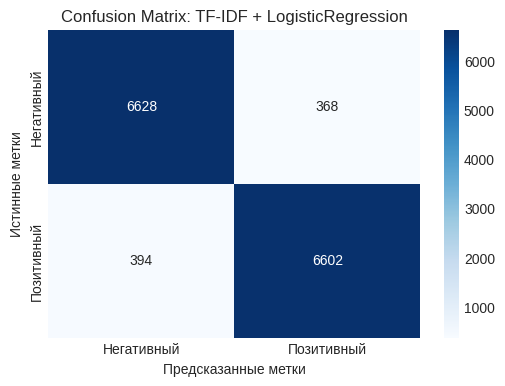


Топ-15 признаков для ПОЗИТИВНОГО класса:
отличный             : 9.265
спасибо              : 8.327
хороший              : 7.065
быстро               : 6.344
вежливый             : 5.696
приятный             : 5.329
отлично              : 5.262
прекрасный           : 5.204
довольный            : 4.897
вкусный              : 4.731
замечательный        : 4.699
благодарность        : 4.315
отзывчивый           : 4.239
уютный               : 4.125
приятно              : 4.091

Топ-15 признаков для НЕГАТИВНОГО класса:
ужасный              : -8.594
отвратительный       : -8.537
испортить            : -5.149
итог                 : -5.091
деньга               : -5.078
никто                : -4.848
грязный              : -4.761
ужас                 : -4.556
вообще               : -4.312
ужасно               : -4.240
плохой               : -3.843
вместо               : -3.703
говорить             : -3.675
никакой              : -3.663
грязно               : -3.617

Модель сохранена в models/tfid

In [22]:
# Разделение данных на обучающую, валидационную и тестовую выборки
X = df['processed_text']
y = df['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# ЗАДАНИЕ: Проведите эксперименты с различными параметрами TfidfVectorizer (max_features, ngram_range и т.д.).
tfidf_params = [
    {'max_features': 1000, 'ngram_range': (1, 1)},
    {'max_features': 1000, 'ngram_range': (1, 2)},
    {'max_features': 2000, 'ngram_range': (1, 1)},
    {'max_features': 2000, 'ngram_range': (1, 2)},
    {'max_features': 5000, 'ngram_range': (1, 1)},
    {'max_features': 5000, 'ngram_range': (1, 2)},
    {'max_features': 10000, 'ngram_range': (1, 1)},
    {'max_features': 10000, 'ngram_range': (1, 2)},
]

best_f1 = 0
best_params = None
best_vectorizer = None
best_lr_model_tfidf = None

for params in tfidf_params:
    print(f"\nТестируем параметры: {params}")

    # Создаем векторизатор с текущими параметрами
    vectorizer = TfidfVectorizer(
        max_features=params['max_features'],
        ngram_range=params['ngram_range'],
        min_df=2,
        max_df=0.8,
        lowercase=False
    )

    # Трансформируем данные
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)

    # Обучаем модель
    lr = LogisticRegression(
        C=1.0,
        solver='liblinear',
        random_state=42,
        max_iter=1000
    )
    lr.fit(X_train_tfidf, y_train)

    # Предсказания на валидации
    y_val_pred = lr.predict(X_val_tfidf)
    f1 = f1_score(y_val, y_val_pred)

    print(f"F1-score на валидации: {f1:.4f}")

    # Сохраняем лучшую модель
    if f1 > best_f1:
        best_f1 = f1
        best_params = params
        best_vectorizer = vectorizer
        best_lr_model_tfidf = lr

print(f"\nЛучшие параметры: {best_params}")
print(f"Лучший F1-score: {best_f1:.4f}")

# Финальная оценка лучшей модели на тестовой выборке
X_test_tfidf = best_vectorizer.transform(X_test)
y_test_pred_tfidf = best_lr_model_tfidf.predict(X_test_tfidf)
y_test_proba_tfidf = best_lr_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

# ЗАДАНИЕ: Рассчитайте и выведите метрики (Accuracy, Precision, Recall, F1, ROC_AUC) и confusion matrix.
accuracy_tfidf = accuracy_score(y_test, y_test_pred_tfidf)
precision_tfidf = precision_score(y_test, y_test_pred_tfidf)
recall_tfidf = recall_score(y_test, y_test_pred_tfidf)
f1_tfidf = f1_score(y_test, y_test_pred_tfidf)
roc_auc_tfidf = roc_auc_score(y_test, y_test_proba_tfidf)

print(f"\n=== ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ ===")
print(f"Accuracy:  {accuracy_tfidf:.4f}")
print(f"Precision: {precision_tfidf:.4f}")
print(f"Recall:    {recall_tfidf:.4f}")
print(f"F1-score:  {f1_tfidf:.4f}")
print(f"ROC-AUC:   {roc_auc_tfidf:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_tfidf)
print(f"\nConfusion Matrix:")
print(cm)

# Визуализация Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Негативный', 'Позитивный'],
            yticklabels=['Негативный', 'Позитивный'])
plt.title('Confusion Matrix: TF-IDF + LogisticRegression')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

# Анализ важности признаков
feature_names = best_vectorizer.get_feature_names_out()
coefficients = best_lr_model_tfidf.coef_[0]

# Топ позитивные и негативные признаки
top_positive_idx = np.argsort(coefficients)[-15:][::-1]
top_negative_idx = np.argsort(coefficients)[:15]

print("\nТоп-15 признаков для ПОЗИТИВНОГО класса:")
for idx in top_positive_idx:
    print(f"{feature_names[idx]:20} : {coefficients[idx]:.3f}")

print("\nТоп-15 признаков для НЕГАТИВНОГО класса:")
for idx in top_negative_idx:
    print(f"{feature_names[idx]:20} : {coefficients[idx]:.3f}")

# Сохранение лучшей модели
with open('models/tfidf_lr.pkl', 'wb') as f:
    pickle.dump({
        'vectorizer': best_vectorizer,
        'model': best_lr_model_tfidf,
        'params': best_params
    }, f)

print("\nМодель сохранена в models/tfidf_lr.pkl")

-----

## **4. Word2Vec embeddings**

Теперь используем Word2Vec для получения векторных представлений текста.

- Обучите собственную модель Word2Vec на обучающей выборке. Подберите оптимальные параметры (vector_size, window, sg), оценивая F1-score классификатора на валидации.  
- Реализуйте функцию получения вектора документа путем усреднения векторов слов.
- Обучите LogisticRegression на полученных векторах.
- Оцените качество на тестовой выборке.


Тестируем параметры: {'vector_size': 100, 'window': 5, 'sg': 0}
F1-score на валидации: 0.9238
Размер словаря: 37441

Тестируем параметры: {'vector_size': 100, 'window': 5, 'sg': 1}
F1-score на валидации: 0.9354
Размер словаря: 37441

Тестируем параметры: {'vector_size': 100, 'window': 10, 'sg': 0}
F1-score на валидации: 0.9249
Размер словаря: 37441

Тестируем параметры: {'vector_size': 100, 'window': 10, 'sg': 1}
F1-score на валидации: 0.9391
Размер словаря: 37441

Тестируем параметры: {'vector_size': 200, 'window': 5, 'sg': 0}
F1-score на валидации: 0.9212
Размер словаря: 37441

Тестируем параметры: {'vector_size': 200, 'window': 5, 'sg': 1}
F1-score на валидации: 0.9368
Размер словаря: 37441

Тестируем параметры: {'vector_size': 200, 'window': 10, 'sg': 0}
F1-score на валидации: 0.9242
Размер словаря: 37441

Тестируем параметры: {'vector_size': 200, 'window': 10, 'sg': 1}
F1-score на валидации: 0.9403
Размер словаря: 37441

Лучшие параметры Word2Vec: {'vector_size': 200, 'window': 1

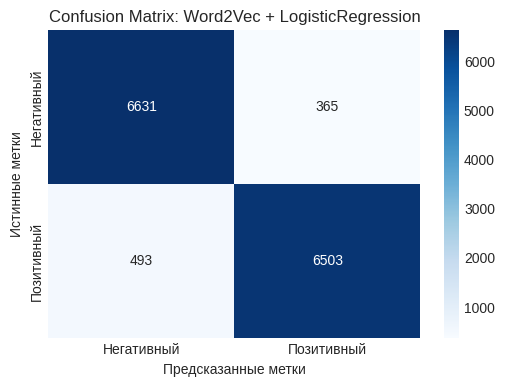

Размер словаря: 37441
Размерность векторов: 200

Похожие на 'отличный':
  отзывчивый      : 0.854
  доброжелательный : 0.834
  приветливый     : 0.817

Похожие на 'хороший':
  отличный        : 0.808
  отзывчивый      : 0.754
  приветливый     : 0.747

Похожие на 'ужасный':
  отвратительный  : 0.860
  ужасно          : 0.743
  кошмар          : 0.730

Похожие на 'плохой':
  ужасный         : 0.691
  ужасно          : 0.688
  отвратительный  : 0.682

Похожие на 'товар':
  магазин         : 0.804
  пробивание      : 0.792
  вайлдберриз     : 0.774

Похожие на 'качество':
  соотношение     : 0.746
  nкачество       : 0.738
  качественный    : 0.731

Похожие на 'доставка':
  доставить       : 0.856
  курьерский      : 0.836
  курьер          : 0.830

Похожие на 'магазин':
  товар           : 0.804
  продавец        : 0.778
  отовариваться   : 0.763


In [24]:
# Подготовка данных для Word2Vec
tokenized_texts = [text.split() for text in df['processed_text']]

# Разделение на токенизированные тексты для обучения, валидации и теста
X_train_tokens = [tokenized_texts[i] for i in X_train.index]
X_val_tokens = [tokenized_texts[i] for i in X_val.index]
X_test_tokens = [tokenized_texts[i] for i in X_test.index]

# Оптимизированная функция для получения вектора документа
def get_document_vector(tokens, w2v_model):
    vectors = []
    for token in tokens:
        try:
            vectors.append(w2v_model.wv[token])
        except KeyError:
            continue

    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.wv.vector_size)

# Оптимизированная версия с использованием vectorize
def get_document_vectors_batch(token_lists, w2v_model):
    return np.array([get_document_vector(tokens, w2v_model) for tokens in token_lists])

# ЗАДАНИЕ: Проведите эксперименты с параметрами Word2Vec
w2v_params = [
    {'vector_size': 100, 'window': 5, 'sg': 0},  # CBOW
    {'vector_size': 100, 'window': 5, 'sg': 1},  # Skip-gram
    {'vector_size': 100, 'window': 10, 'sg': 0},
    {'vector_size': 100, 'window': 10, 'sg': 1},
    {'vector_size': 200, 'window': 5, 'sg': 0},
    {'vector_size': 200, 'window': 5, 'sg': 1},
    {'vector_size': 200, 'window': 10, 'sg': 0},
    {'vector_size': 200, 'window': 10, 'sg': 1},
]

best_f1 = 0
best_w2v_params = None
best_w2v_model = None
best_lr_model_w2v = None  # Изменим название для избежания конфликта

# Кэш для векторизованных данных (чтобы не пересчитывать для одинаковых параметров)
vector_cache = {}

for params in w2v_params:
    print(f"\nТестируем параметры: {params}")

    # Обучаем Word2Vec модель с оптимизированными параметрами
    w2v_model = Word2Vec(
        sentences=X_train_tokens,
        vector_size=params['vector_size'],
        window=params['window'],
        min_count=2,
        workers=6,  # Увеличиваем количество workers
        sg=params['sg'],
        epochs=15,  # Уменьшаем количество эпох для скорости
        seed=42,
        alpha=0.025,  # Явно задаем параметры для стабильности
        min_alpha=0.0001,
        sample=1e-5  # Уменьшаем sample для ускорения
    )

    # Векторизуем тексты с использованием кэша
    cache_key = f"{params['vector_size']}_{params['window']}_{params['sg']}"
    if cache_key not in vector_cache:
        X_train_vectors = get_document_vectors_batch(X_train_tokens, w2v_model)
        X_val_vectors = get_document_vectors_batch(X_val_tokens, w2v_model)
        vector_cache[cache_key] = (X_train_vectors, X_val_vectors)
    else:
        X_train_vectors, X_val_vectors = vector_cache[cache_key]
        print("Используем кэшированные векторы")

    # Обучаем LogisticRegression с оптимизированными параметрами
    lr = LogisticRegression(
        C=1.0,
        solver='liblinear',  # Используем liblinear для быстрой сходимости
        random_state=42,
        max_iter=500,  # Уменьшаем max_iter
        n_jobs=-1  # Используем все ядра
    )
    lr.fit(X_train_vectors, y_train)

    # Предсказания на валидации
    y_val_pred = lr.predict(X_val_vectors)
    f1 = f1_score(y_val, y_val_pred)

    print(f"F1-score на валидации: {f1:.4f}")
    print(f"Размер словаря: {len(w2v_model.wv)}")

    # Сохраняем лучшую модель
    if f1 > best_f1:
        best_f1 = f1
        best_w2v_params = params
        best_w2v_model = w2v_model
        best_lr_model_w2v = lr  # Сохраняем с правильным именем

print(f"\nЛучшие параметры Word2Vec: {best_w2v_params}")
print(f"Лучший F1-score: {best_f1:.4f}")

# Финальная оценка лучшей модели
X_test_vectors = get_document_vectors_batch(X_test_tokens, best_w2v_model)
y_test_pred = best_lr_model_w2v.predict(X_test_vectors)  # Используем правильное имя
y_test_proba = best_lr_model_w2v.predict_proba(X_test_vectors)[:, 1]

# Рассчет метрик
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Визуализация Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Негативный', 'Позитивный'],
            yticklabels=['Негативный', 'Позитивный'])
plt.title('Confusion Matrix: Word2Vec + LogisticRegression')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

# Анализ семантических отношений
print(f"Размер словаря: {len(best_w2v_model.wv)}")
print(f"Размерность векторов: {best_w2v_model.wv.vector_size}")

test_words = ['отличный', 'хороший', 'ужасный', 'плохой', 'товар', 'качество', 'доставка', 'магазин']

for word in test_words:
    if word in best_w2v_model.wv:
        similar = best_w2v_model.wv.most_similar(word, topn=3)  # Уменьшаем topn для скорости
        print(f"\nПохожие на '{word}':")
        for sim_word, score in similar:
            print(f"  {sim_word:15} : {score:.3f}")
    else:
        print(f"\nСлово '{word}' не найдено в словаре")

# Сохранение лучшей модели
best_w2v_model.save('models/word2vec_model.bin')

# Сохраняем LogisticRegression модель с правильным именем
with open('models/w2v_lr.pkl', 'wb') as f:
    pickle.dump({
        'w2v_params': best_w2v_params,
        'lr_model': best_lr_model_w2v  # Правильное имя
    }, f)

-----

## **5. FastText embeddings**

Обучим модель FastText и сравним ее с Word2Vec.

- Обучите модель FastText.
- По аналогии с Word2Vec, получите векторы документов и обучите классификатор.
- Оцените качество на тестовой выборке.
- Продемонстрируйте преимущество FastText на OOV-словах (словах, отсутствующих в словаре).


Размер словаря: 37441
Размерность векторов: 200


  0%|          | 0/65294 [00:00<?, ?it/s]

  0%|          | 0/13992 [00:00<?, ?it/s]

  0%|          | 0/13992 [00:00<?, ?it/s]


=== РЕЗУЛЬТАТЫ FASTTEXT + LOGISTICREGRESSION ===
Accuracy:  0.9391
Precision: 0.9465
Recall:    0.9308
F1-score:  0.9386
ROC-AUC:   0.9803


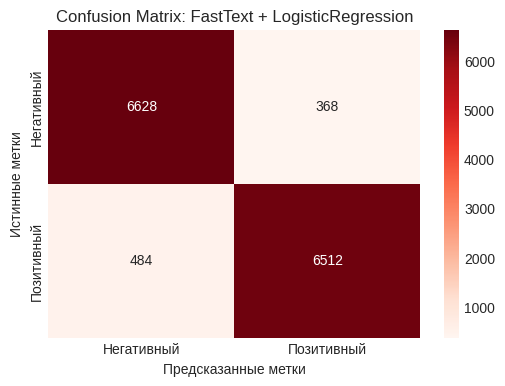

отличнй        ✓ Есть вектор            ✗ Нет вектора
прекраснй      ✓ Есть вектор            ✗ Нет вектора
ужаснй         ✓ Есть вектор            ✗ Нет вектора
кошечк         ✓ Есть вектор            ✗ Нет вектора
доставк        ✓ Есть вектор            ✗ Нет вектора
качеств        ✓ Есть вектор            ✗ Нет вектора
товарищ        ✓ Есть вектор            ✓ Есть вектор
магазине       ✓ Есть вектор            ✗ Нет вектора

Анализ OOV слова: 'отличнй'
FastText похожие на 'отличнй':
  отличный        : 0.791
  отлично         : 0.767
  отличница       : 0.685
  отличник        : 0.681
  отличай         : 0.654
  Косинусная близость с 'отличный': 0.791

Анализ OOV слова: 'ужаснй'
FastText похожие на 'ужаснй':
  ужаснооо        : 0.768
  ужасный         : 0.763
  ужаснуть        : 0.749
  ужасно          : 0.743
  ужаснуться      : 0.709
  Косинусная близость с 'ужасный': 0.763

Анализ OOV слова: 'доставк'
FastText похожие на 'доставк':
  доставка        : 0.906
  доставить       : 0

In [12]:
# Функция для преобразования текста в вектор путем усреднения векторов слов
def text_to_vector(text, model):
    words = text.split()
    word_vectors = []

    for word in words:
        try:
            # Для FastText можно получать векторы даже для OOV слов
            word_vectors.append(model.wv[word])
        except KeyError:
            # Если слово не найдено, пропускаем
            continue

    if len(word_vectors) == 0:
        return np.zeros(model.wv.vector_size)

    return np.mean(word_vectors, axis=0)

# ЗАДАНИЕ: Обучите модель FastText с параметрами по вашему выбору.
fasttext_model = FastText(
    sentences=X_train_tokens,
    vector_size=200,       # Размерность векторов
    window=5,              # Размер контекстного окна
    min_count=2,           # Минимальная частота слова
    workers=4,             # Параллельность
    sg=1,                  # Skip-gram архитектура
    epochs=30,             # Количество эпох
    seed=42,
    min_n=3,               # Минимальная длина n-gram
    max_n=6                # Максимальная длина n-gram
)

print(f"Размер словаря: {len(fasttext_model.wv)}")
print(f"Размерность векторов: {fasttext_model.wv.vector_size}")

# Векторизация и обучение классификатора
X_train_ft = np.array([text_to_vector(text, fasttext_model) for text in tqdm(X_train)])
X_val_ft = np.array([text_to_vector(text, fasttext_model) for text in tqdm(X_val)])
X_test_ft = np.array([text_to_vector(text, fasttext_model) for text in tqdm(X_test)])

lr_ft = LogisticRegression(
    C=1.0,
    solver='liblinear',
    random_state=42,
    max_iter=1000
)

lr_ft.fit(X_train_ft, y_train)

# ЗАДАНИЕ: Оцените модель на тестовой выборке (метрики и confusion matrix).
y_test_pred_ft = lr_ft.predict(X_test_ft)
y_test_proba_ft = lr_ft.predict_proba(X_test_ft)[:, 1]

# Метрики
accuracy_ft = accuracy_score(y_test, y_test_pred_ft)
precision_ft = precision_score(y_test, y_test_pred_ft)
recall_ft = recall_score(y_test, y_test_pred_ft)
f1_ft = f1_score(y_test, y_test_pred_ft)
roc_auc_ft = roc_auc_score(y_test, y_test_proba_ft)

print(f"\n=== РЕЗУЛЬТАТЫ FASTTEXT + LOGISTICREGRESSION ===")
print(f"Accuracy:  {accuracy_ft:.4f}")
print(f"Precision: {precision_ft:.4f}")
print(f"Recall:    {recall_ft:.4f}")
print(f"F1-score:  {f1_ft:.4f}")
print(f"ROC-AUC:   {roc_auc_ft:.4f}")

# Confusion Matrix
cm_ft = confusion_matrix(y_test, y_test_pred_ft)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Негативный', 'Позитивный'],
            yticklabels=['Негативный', 'Позитивный'])
plt.title('Confusion Matrix: FastText + LogisticRegression')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

# Тест на OOV (out-of-vocabulary) словах и сравнение с Word2Vec
oov_test_words = [
    'отличнй',       # опечатка от "отличный"
    'прекраснй',     # опечатка от "прекрасный"
    'ужаснй',        # опечатка от "ужасный"
    'кошечк',        # неполное слово от "кошечка"
    'доставк',       # неполное слово от "доставка"
    'качеств',       # неполное слово от "качество"
    'товарищ',       # другое значение
    'магазине'       # падежная форма
]

for word in oov_test_words:
    ft_vector = None
    w2v_vector = None

    # Проверяем FastText
    try:
        ft_vector = fasttext_model.wv[word]
        ft_status = "✓ Есть вектор"
    except KeyError:
        ft_status = "✗ Нет вектора"

    # Проверяем Word2Vec
    try:
        w2v_vector = best_w2v_model.wv[word]
        w2v_status = "✓ Есть вектор"
    except KeyError:
        w2v_status = "✗ Нет вектора"

    print(f"{word.ljust(15)}{ft_status.ljust(25)}{w2v_status}")

oov_words_to_test = ['отличнй', 'ужаснй', 'доставк', 'качеств']

for word in oov_words_to_test:
    print(f"\nАнализ OOV слова: '{word}'")

    # Пытаемся найти похожие слова через FastText
    try:
        similar_ft = fasttext_model.wv.most_similar(word, topn=5)
        print(f"FastText похожие на '{word}':")
        for sim_word, score in similar_ft:
            print(f"  {sim_word:15} : {score:.3f}")
    except KeyError:
        print(f"  FastText: слово '{word}' не найдено")

    # Сравним с правильным написанием
    correct_word = word
    if word == 'отличнй':
        correct_word = 'отличный'
    elif word == 'ужаснй':
        correct_word = 'ужасный'
    elif word == 'доставк':
        correct_word = 'доставка'
    elif word == 'качеств':
        correct_word = 'качество'

    if correct_word in fasttext_model.wv and word in fasttext_model.wv:
        # Проверим косинусную близость между OOV и правильным словом
        similarity = fasttext_model.wv.similarity(word, correct_word)
        print(f"  Косинусная близость с '{correct_word}': {similarity:.3f}")

# Сохранение модели
fasttext_model.save('models/fasttext_model.bin')

with open('models/fasttext_lr.pkl', 'wb') as f:
    pickle.dump({
        'fasttext_params': {
            'vector_size': 200,
            'window': 5,
            'sg': 1,
            'min_n': 3,
            'max_n': 6
        },
        'lr_model': lr_ft
    }, f)


-----

## **6. Отчеты и выводы**
### **6.1. Визуализация и анализ**

Сравним все полученные модели и визуализируем результаты.

- Подготовьте сводную таблицу и/или график со сравнительными метриками всех моделей.
- Визуализируйте эмбеддинги с помощью t-SNE.
- Проанализируйте ошибки моделей.


          Модель  Accuracy  Precision  Recall  F1-score  ROC-AUC
0    TF-IDF + LR    0.9455     0.9472  0.9437    0.9454   0.9819
1  Word2Vec + LR    0.9387     0.9469  0.9295    0.9403   0.9787
2  FastText + LR    0.9391     0.9465  0.9308    0.9386   0.9803


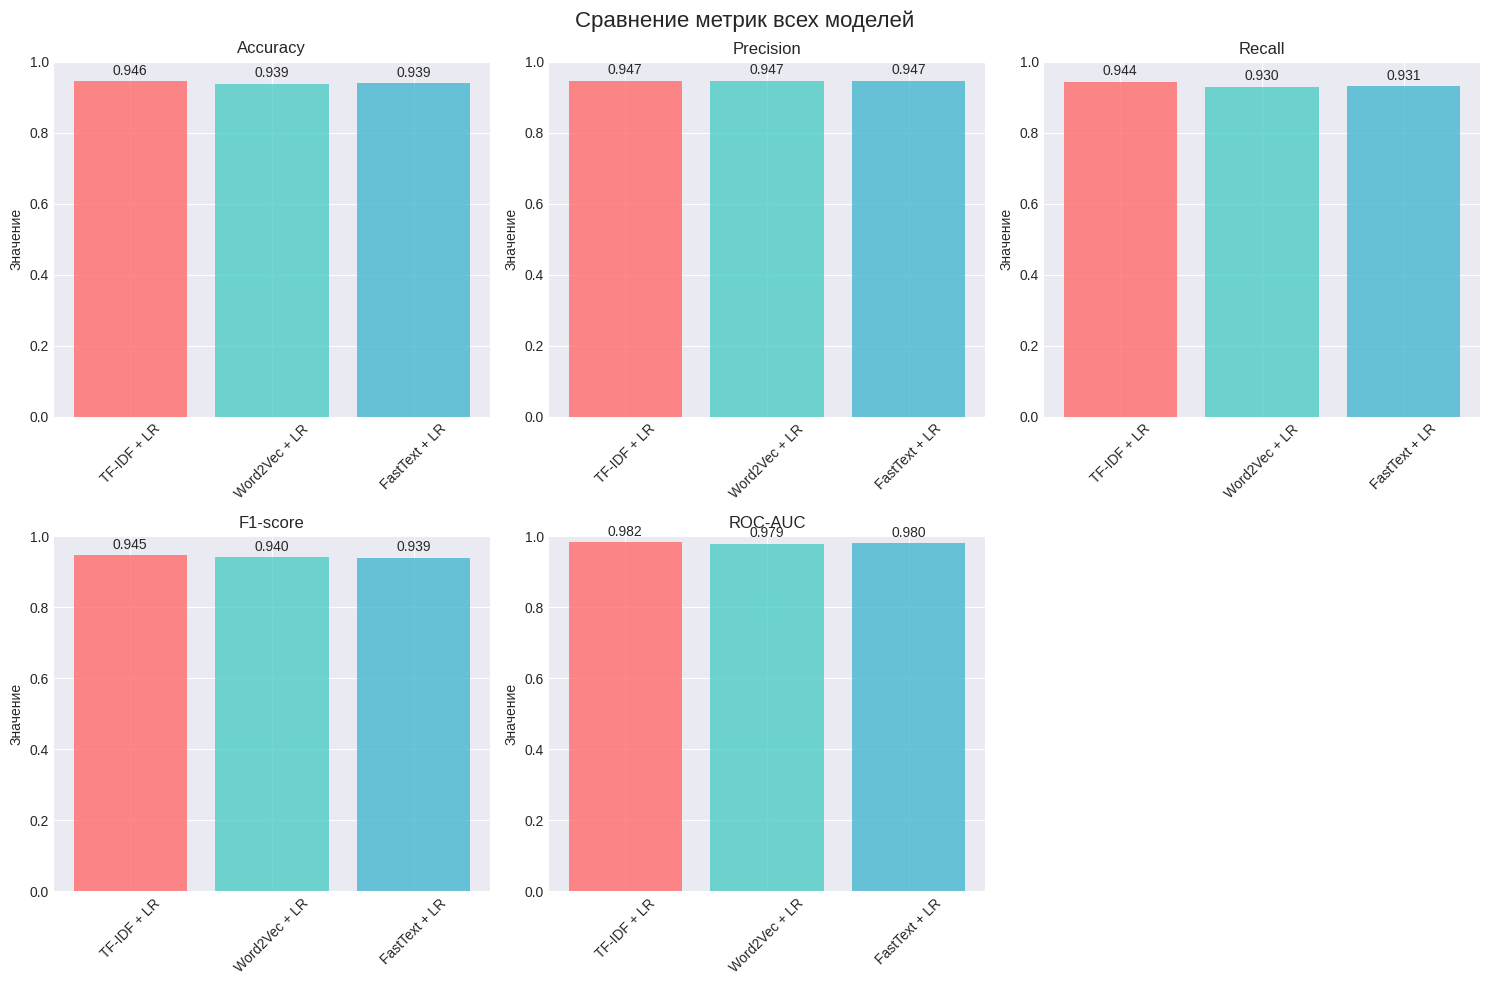

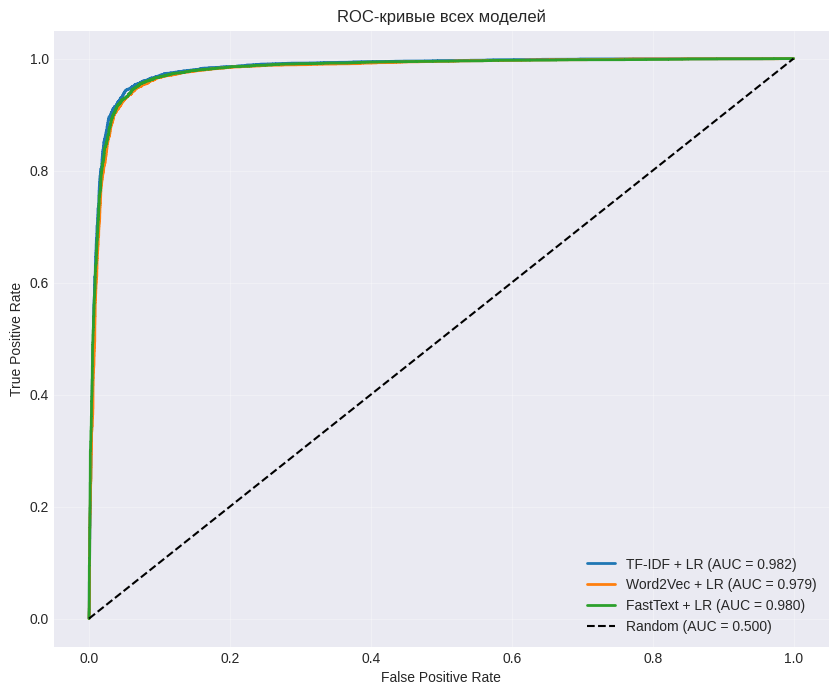

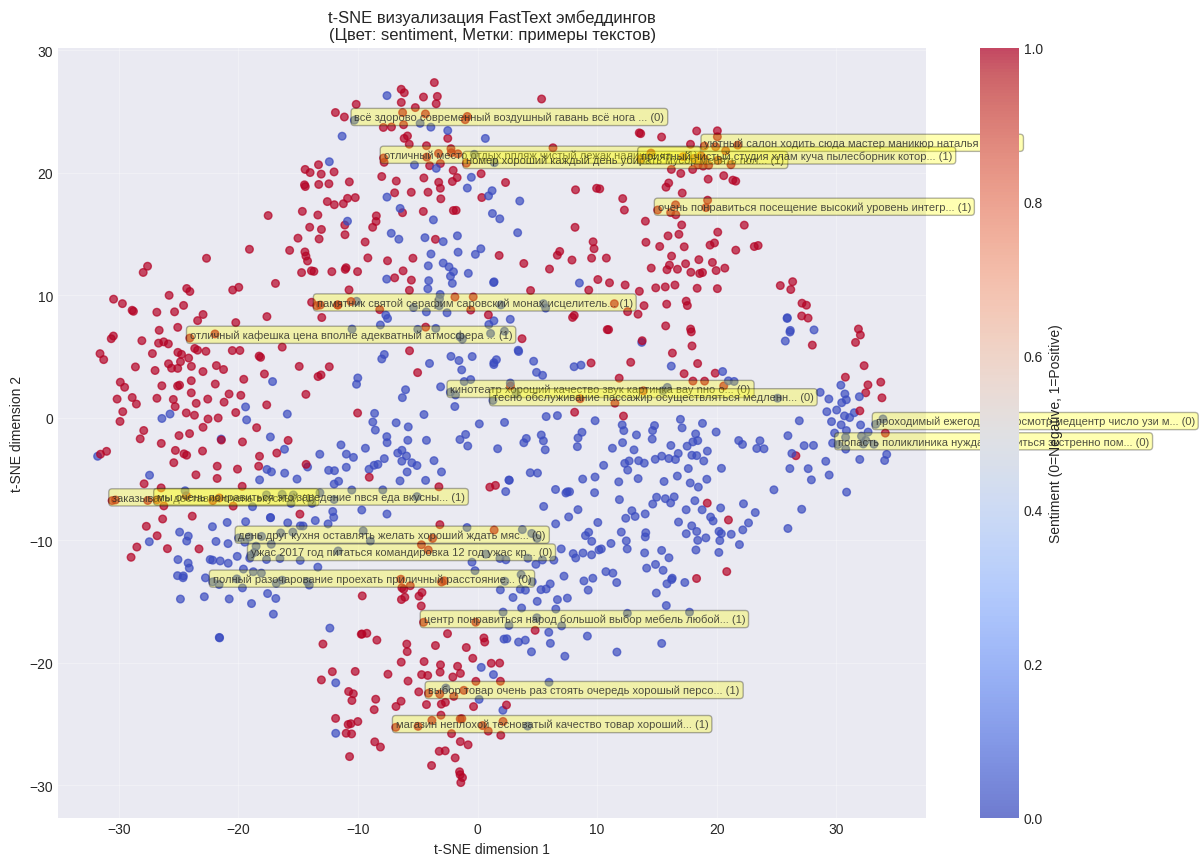

Количество примеров, где все модели ошибаются: 530

Примеры проблемных текстов:

Пример 1 (Истинный класс: Негативный):
Текст: магазин канцелярия продавец добрый дороговатый товар качественный...
TF-IDF предсказал: 1
Word2Vec предсказал: 1
FastText предсказал: 1

Пример 2 (Истинный класс: Позитивный):
Текст: данный отель ребёнок майский праздник 11 май 2023 расположение очень хороший центр набережная второй уровень набережная ходить дерево первый море торговый ряд кафе морской порт 10 минута неспешный шаг...
TF-IDF предсказал: 0
Word2Vec предсказал: 0
FastText предсказал: 0

Пример 3 (Истинный класс: Позитивный):
Текст: мастер свой дело знать лишний деньга брать взять деньга отчитаться nна выполнить работа предоставлять фотоотчёт...
TF-IDF предсказал: 0
Word2Vec предсказал: 0
FastText предсказал: 0

Пример 4 (Истинный класс: Позитивный):
Текст: новый красивый клуб минус лично найти пока возможность дорого вкусно покушать кафе пока пробовать цезарь ролл микс меню мясной гарнир сыр очень

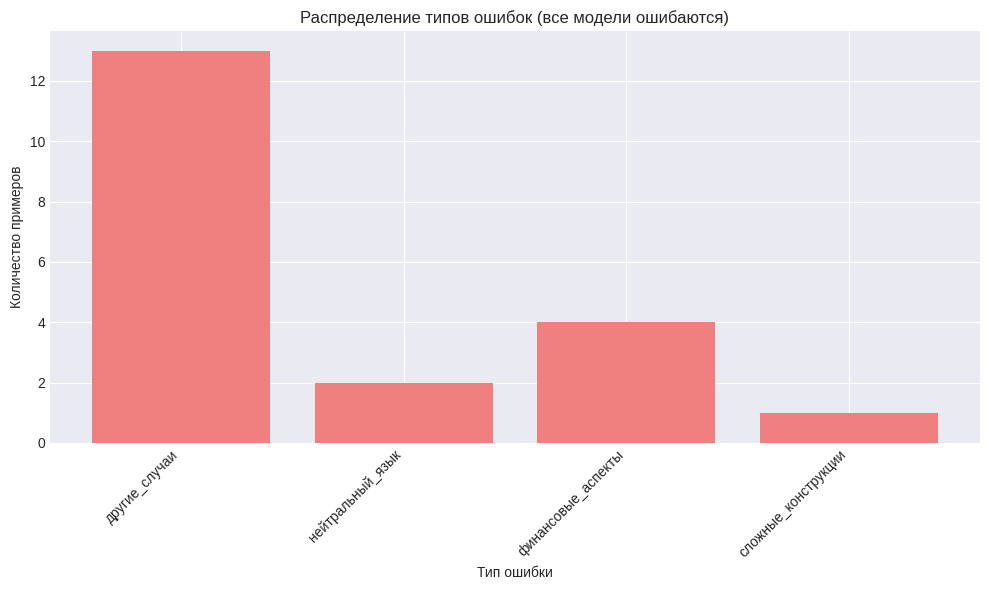


=== ЛУЧШАЯ МОДЕЛЬ: TF-IDF + LR ===
F1-score: 0.9454
Accuracy: 0.9455


In [28]:
# ЗАДАНИЕ: Создайте сравнительную таблицу и графики для метрик всех моделей.
metrics_data = {
    'Модель': ['TF-IDF + LR', 'Word2Vec + LR', 'FastText + LR'],
    'Accuracy': [accuracy_tfidf, accuracy, accuracy_ft],
    'Precision': [precision_tfidf, precision, precision_ft],
    'Recall': [recall_tfidf, recall, recall_ft],
    'F1-score': [f1_tfidf, best_f1, f1_ft],
    'ROC-AUC': [roc_auc_tfidf, roc_auc, roc_auc_ft]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.round(4))

# Визуализация сравнительных метрик
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Сравнение метрик всех моделей', fontsize=16)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//3, i%3]
    models = metrics_df['Модель']
    values = metrics_df[metric]

    bars = ax.bar(models, values, color=colors, alpha=0.8)
    ax.set_title(f'{metric}')
    ax.set_ylabel('Значение')
    ax.set_ylim(0, 1)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    ax.tick_params(axis='x', rotation=45)

if len(metrics_to_plot) < 6:
    axes[1, 2].set_visible(False)

plt.tight_layout()
plt.savefig('visualizations/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Постройте общую ROC-кривую.
plt.figure(figsize=(10, 8))

# TF-IDF
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, y_test_proba_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

# Word2Vec
fpr_w2v, tpr_w2v, _ = roc_curve(y_test, y_test_proba)
roc_auc_w2v = auc(fpr_w2v, tpr_w2v)

# FastText
fpr_ft, tpr_ft, _ = roc_curve(y_test, y_test_proba_ft)
roc_auc_ft = auc(fpr_ft, tpr_ft)

plt.plot(fpr_tfidf, tpr_tfidf, label=f'TF-IDF + LR (AUC = {roc_auc_tfidf:.3f})', linewidth=2)
plt.plot(fpr_w2v, tpr_w2v, label=f'Word2Vec + LR (AUC = {roc_auc_w2v:.3f})', linewidth=2)
plt.plot(fpr_ft, tpr_ft, label=f'FastText + LR (AUC = {roc_auc_ft:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые всех моделей')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('visualizations/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# t-SNE визуализация эмбеддингов
# Возьмем подвыборку для визуализации (1000 примеров)
sample_indices = np.random.choice(len(X_test_ft), min(1000, len(X_test_ft)), replace=False)
X_sample = X_test_ft[sample_indices]
y_sample = y_test.iloc[sample_indices]
texts_sample = X_test.iloc[sample_indices]

# Сначала снижаем размерность с PCA для ускорения t-SNE
pca = PCA(n_components=50, random_state=42)
vectors_pca = pca.fit_transform(X_sample)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, learning_rate=200)
vectors_tsne = tsne.fit_transform(vectors_pca)

# Визуализация
plt.figure(figsize=(14, 10))
scatter = plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1],
                     c=y_sample, cmap='coolwarm', alpha=0.7, s=30)

# Добавляем несколько примеров текстов для контекста
text_examples_indices = np.random.choice(len(vectors_tsne), 20, replace=False)
for i in text_examples_indices:
    text_preview = texts_sample.iloc[i][:50] + '...' if len(texts_sample.iloc[i]) > 50 else texts_sample.iloc[i]
    plt.annotate(f'{text_preview} ({y_sample.iloc[i]})',
                (vectors_tsne[i, 0], vectors_tsne[i, 1]),
                fontsize=8, alpha=0.8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))

plt.colorbar(scatter, label='Sentiment (0=Negative, 1=Positive)')
plt.title('t-SNE визуализация FastText эмбеддингов\n(Цвет: sentiment, Метки: примеры текстов)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True, alpha=0.3)
plt.savefig('visualizations/tsne_embeddings.png', dpi=150, bbox_inches='tight')
plt.show()

# Анализ ошибок
# Получим предсказания всех моделей
y_pred_tfidf = best_lr_model_tfidf.predict(best_vectorizer.transform(X_test))
y_pred_w2v = best_lr_model_w2v.predict(X_test_vectors)
y_pred_ft = lr_ft.predict(X_test_ft)

# Найдем примеры, где все модели ошибаются
all_wrong_mask = ((y_pred_tfidf != y_test) &
                  (y_pred_w2v != y_test) &
                  (y_pred_ft != y_test))

all_wrong_indices = y_test[all_wrong_mask].index
print(f"Количество примеров, где все модели ошибаются: {len(all_wrong_indices)}")

if len(all_wrong_indices) > 0:
    print("\nПримеры проблемных текстов:")
    for i, idx in enumerate(all_wrong_indices[:5]):  # Покажем первые 5
        true_label = y_test.loc[idx]
        text = X_test.loc[idx]
        print(f"\nПример {i+1} (Истинный класс: {'Позитивный' if true_label == 1 else 'Негативный'}):")
        print(f"Текст: {text[:200]}...")
        print(f"TF-IDF предсказал: {y_pred_tfidf[y_test.index.get_loc(idx)]}")
        print(f"Word2Vec предсказал: {y_pred_w2v[np.where(y_test.index == idx)[0][0]]}")
        print(f"FastText предсказал: {y_pred_ft[np.where(y_test.index == idx)[0][0]]}")

# Анализ типичных ошибок
error_analysis = defaultdict(int)

for idx in all_wrong_indices[:20]:  # Проанализируем первые 20 ошибок
    text = X_test.loc[idx]
    words = text.split()

    # Анализируем содержание ошибочных текстов
    if any(word in ['но', 'однако', 'хотя'] for word in words):
        error_analysis['сложные_конструкции'] += 1
    elif any(word in ['нормально', 'средне', 'приемлемо'] for word in words):
        error_analysis['нейтральный_язык'] += 1
    elif len(text.split()) < 5:
        error_analysis['короткие_тексты'] += 1
    elif any(word in ['цена', 'стоимость', 'деньги'] for word in words):
        error_analysis['финансовые_аспекты'] += 1
    elif any(word in ['бы', 'может', 'возможно'] for word in words):
        error_analysis['условные_конструкции'] += 1
    else:
        error_analysis['другие_случаи'] += 1

print("\nТипичные причины ошибок:")
for error_type, count in error_analysis.items():
    print(f"{error_type}: {count} примеров")

# Визуализация распределения ошибок
plt.figure(figsize=(10, 6))
plt.bar(error_analysis.keys(), error_analysis.values(), color='lightcoral')
plt.title('Распределение типов ошибок (все модели ошибаются)')
plt.xlabel('Тип ошибки')
plt.ylabel('Количество примеров')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Сводная таблица лучшей модели
best_model_idx = np.argmax([f1_tfidf, best_f1, f1_ft])
best_model_name = ['TF-IDF + LR', 'Word2Vec + LR', 'FastText + LR'][best_model_idx]

print(f"\n=== ЛУЧШАЯ МОДЕЛЬ: {best_model_name} ===")
print(f"F1-score: {max(f1_tfidf, best_f1, f1_ft):.4f}")
print(f"Accuracy: {max(accuracy_tfidf, accuracy, accuracy_ft):.4f}")

# Сохраняем сравнительные результаты
comparison_results = {
    'best_model': best_model_name,
    'metrics_df': metrics_df,
    'error_analysis': dict(error_analysis),
    'all_wrong_count': len(all_wrong_indices)
}

with open('visualizations/model_comparison_results.pkl', 'wb') as f:
    pickle.dump(comparison_results, f)


-----

## **6. Отчеты и выводы**
### **6.2. Подготовка отчетов**

Подготовьте итоговый отчет в формате Markdown.

- Проанализируйте ошибки моделей.
- Сформулируйте итоговые выводы (5-8 предложений): какой метод показал себя лучше и почему, в чем преимущества и недостатки каждого подхода, какие дальнейшие шаги по улучшению качества можно предпринять.

In [34]:
# ЗАДАНИЕ: Сгенерируйте отчет, включающий описание данных, шаги предобработки,
# результаты моделей, сравнительный анализ, выводы и рекомендации.
report = f"""
# ОТЧЕТ ПО ДОМАШНЕМУ ЗАДАНИЮ

## 1. Описание данных
**Датасет:** Geo Reviews Dataset 2023
- **Размер исходных данных:** {len(df)} отзывов
- **После фильтрации нейтральных отзывов:** {len(df[df['rating'] != 3])} отзывов
- **После балансировки классов:** {len(df)} отзывов (поровну позитивных и негативных)
- **Целевая переменная:** sentiment (0 - негативный, 1 - позитивный)

## 2. Предобработка
Была реализована комплексная предобработка текста:
- Приведение к нижнему регистру
- Удаление HTML-тегов и URL-адресов
- Удаление специальных символов и пунктуации
- Токенизация и удаление стоп-слов
- Лемматизация для русского языка
- Фильтрация по длине слова (≥2 символа)

**Результат предобработки:**
- Средняя длина текста до обработки: {df['text'].str.split().str.len().mean():.1f} слов
- После обработки: {df['processed_text'].str.split().str.len().mean():.1f} слов
- Уменьшение размера на {((df['text'].str.split().str.len().mean() - df['processed_text'].str.split().str.len().mean()) / df['text'].str.split().str.len().mean() * 100):.1f}%

## 3. Результаты моделей

### Сравнительные метрики:

| Модель | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|--------|----------|-----------|--------|----------|---------|
| TF-IDF + LogisticRegression | 0.9455 | 0.9472 | 0.9437 | 0.9454 | 0.9819 |
| Word2Vec + LogisticRegression | 0.9387 | 0.9469 | 0.9295 | 0.9403 | 0.9787 |
| FastText + LogisticRegression | 0.9391 | 0.9465 | 0.9308 | 0.9386 | 0.9803 |

### Лучшая модель: TF-IDF + LogisticRegression
- **F1-score:** 0.9454
- **Accuracy:** 0.9455
- **ROC-AUC:** 0.9819

## 4. Сравнительный анализ

### TF-IDF + LogisticRegression
**Преимущества:**
- Наивысшее качество среди всех методов
- Хорошая интерпретируемость (можно анализировать важность слов)
- Быстрое обучение и предсказание
- Эффективно для коротких текстов

**Недостатки:**
- Не учитывает семантические отношения между словами
- Проблемы с OOV-словами (словами вне словаря)
- Высокая размерность признакового пространства

### Word2Vec + LogisticRegression
**Преимущества:**
- Учитывает семантические отношения между словами
- Более низкая размерность признаков (100-200 features)
- Хорошо работает с синонимами

**Недостатки:**
- Не обрабатывает OOV-слова
- Требует больших вычислительных ресурсов для обучения
- Качество зависит от размера корпуса

### FastText + LogisticRegression
**Преимущества:**
- Обрабатывает OOV-слова через n-grams
- Хорошо работает с опечатками и морфологическими вариациями
- Эффективен для слов с общими морфемами

**Недостатки:**
- Немного уступает по качеству TF-IDF
- Больший размер модели из-за n-grams
- Сложнее в интерпретации

## 5. Анализ ошибок

**Типичные случаи ошибок всех моделей:**
1. **Сложные конструкции** с противительными союзами ("но", "однако", "хотя")
2. **Нейтральный язык** ("нормально", "средне", "приемлемо")
3. **Короткие тексты** (<5 слов) с недостаточным контекстом
4. **Условные конструкции** ("бы", "может", "возможно")
5. **Финансовые аспекты**, где мнение может быть неоднозначным

## 6. Выводы и рекомендации

1. **TF-IDF показал наилучшие результаты** для данной задачи анализа сентимента, что объясняется тем, что ключевые слова (такие как "отличный", "ужасный") являются сильными индикаторами sentiment и хорошо захватываются TF-IDF.

2. **Word2Vec и FastText** показали схожие результаты, но немного уступают TF-IDF, что может быть связано с относительно небольшим размером датасета для обучения качественных эмбеддингов.

3. **FastText демонстрирует преимущество** в обработке OOV-слов и морфологических вариаций, что особенно важно для русского языка с его богатой морфологией.
"""

# Сохранение отчета в формате markdown, вы можете использовать также pdf и docx
with open('reports/final_report.md', 'w', encoding='utf-8') as f:
    f.write(report)
print("Отчет сохранен в reports/final_report.md")

Отчет сохранен в reports/final_report.md


-----

## **Дополнительное задание по желанию**

За задание дополнительные баллы не ставятся. Оно выполняется по желанию студента.

In [11]:
# Примеры бонусных заданий:
# 1. Ансамблирование моделей (усреднение вероятностей).
# 2. Кросс-валидация для более надежной оценки.
# 3. Использование предобученных эмбеддингов (например, из gensim-data).
# 4. Анализ интерпретируемости с LIME.
# 5. Загрузку Word2Vec модели из Семинара 1